# **Assignment: SemEval 2025 Task 9 - Food Hazard Detection Challenge**

This assignment tasks us with participating in the **SemEval 2025 Task 9: The Food Hazard Detection Challenge**. The goal is to explore and classify food hazard incidents based on text data, specifically focusing on food recall reports from various web sources. we will work with both short texts (titles) and long texts (full descriptions) provided in the dataset, performing a series of benchmark analyses using basic and advanced machine learning algorithms.

The assignment is structured into two key benchmark analyses:
1. **Short Texts (Titles)**: We will evaluate the performance of text classification models on food hazard prediction based solely on the titles of food incident reports.
2. **Long Texts (Full Descriptions)**: We will extend the analysis to the full recall descriptions to assess whether longer text data improves the classification performance.

We will train and evaluate models such as **Logistic Regression** and **Naive Bayes** for basic machine learning algorithms, and an **advanced BERT-based model** for more sophisticated, transformer-based classification. The performance of the models will be evaluated based on the **macro F1-score** for both hazard and product category prediction.

By the end of the assignment, we will compare the results from these models, determine which approach performs best, and prepare our predictions for submission. The final submission will include the prediction results, along with an explanation of the models used, evaluation metrics, and our ranking on the competition leaderboard.


In [66]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# import shap
# import lime
# from lime.lime_text import LimeTextExplainer

## Step 1: Data Exploration and Preprocessing

In this step, we will load and explore the provided dataset to understand its structure. We will check for any missing data, imbalances in the labels, and perform basic data cleaning tasks. We'll also explore both the short and long text features.

### Loading the Dataset


In [ ]:
# Path to our working directory
wrk_directory_path = '/'.join(os.getcwd().split("/")[:-1])

# Load the dataset
train_data = pd.read_csv(wrk_directory_path + '/Data/incidents_train.csv')

# Preview the first few rows of the data
train_data.head()

,Unnamed: 0,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [13]:
# Drop the "Unnamed: 0" column if it exists
train_data = train_data.drop(columns=['Unnamed: 0'])

### Check Dataframe Information and Data Types

Let’s inspect the structure of the dataset by checking the data types of each column and ensuring that the dataset is loaded correctly. This will help us spot any inconsistencies or issues before proceeding with preprocessing.


In [14]:
# Check the dataframe information and data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              5082 non-null   int64 
 1   month             5082 non-null   int64 
 2   day               5082 non-null   int64 
 3   country           5082 non-null   object
 4   title             5082 non-null   object
 5   text              5082 non-null   object
 6   hazard-category   5082 non-null   object
 7   product-category  5082 non-null   object
 8   hazard            5082 non-null   object
 9   product           5082 non-null   object
dtypes: int64(3), object(7)
memory usage: 397.2+ KB


### Checking for Missing Data

We need to ensure that there are no missing values in the dataset before proceeding with model training.

In [15]:
train_data.isnull().sum()

year                0
month               0
day                 0
country             0
title               0
text                0
hazard-category     0
product-category    0
hazard              0
product             0
dtype: int64

### Visualizing Label Distribution

Before model training, let's visualize the class distribution for both `product-category` and `hazard-category` labels.

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/1625240831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index, palette='viridis')


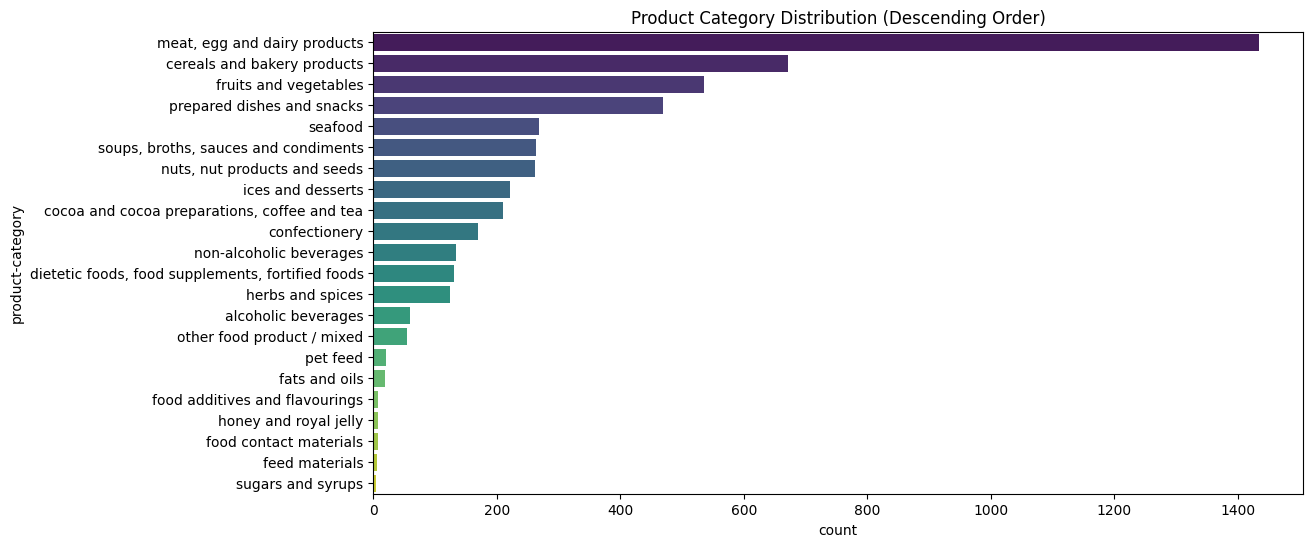

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/1625240831.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index, palette='viridis')


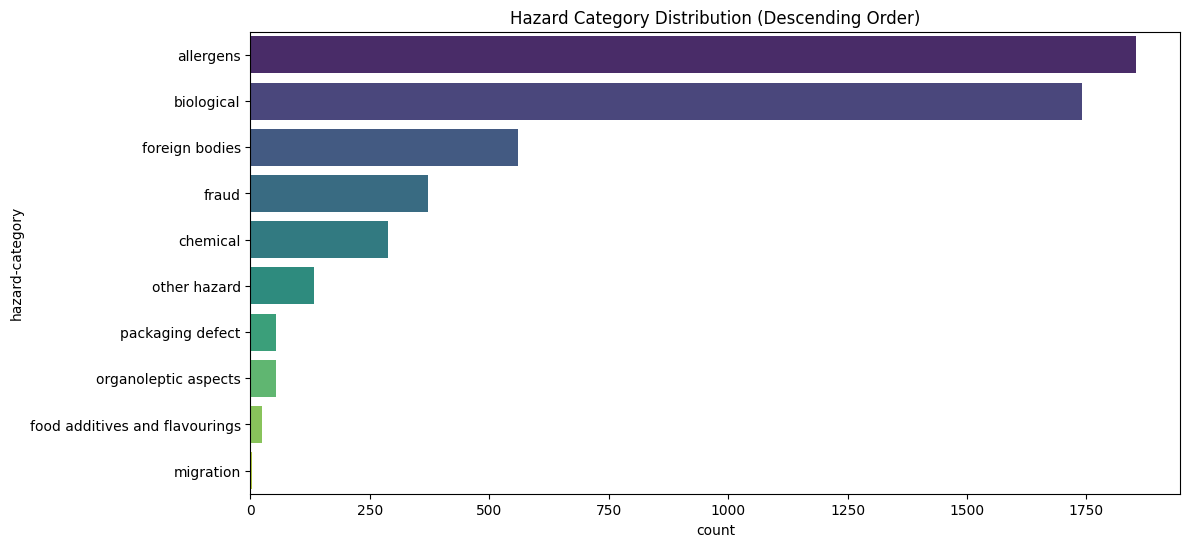

In [ ]:
# Visualizing class distribution for 'product-category' and 'hazard-category' in descending order
plt.figure(figsize=(12, 6))
sns.countplot(y='product-category', data=train_data, order=train_data['product-category'].value_counts().index, palette='viridis')
plt.title('Product Category Distribution (Descending Order)')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y='hazard-category', data=train_data, order=train_data['hazard-category'].value_counts().index, palette='viridis')
plt.title('Hazard Category Distribution (Descending Order)')
plt.show()


### **Product Category Distribution Analysis**

The `product-category` column shows a clear class imbalance, with some categories being significantly more frequent than others. Here’s a breakdown of the distribution:

- **High Frequency Categories**: 
    - "meat, egg and dairy products" (1434 occurrences) is the most frequent category by far.
    - Other relatively frequent categories include "cereals and bakery products" (671), "fruits and vegetables" (535), and "prepared dishes and snacks" (469).

- **Medium Frequency Categories**:
    - Categories like "seafood" (268), "soups, broths, sauces and condiments" (264), and "nuts, nut products and seeds" (262) are still moderately frequent but represent a smaller portion of the dataset.

- **Low Frequency Categories**:
    - Categories such as "pet feed" (20), "fats and oils" (19), and "food additives and flavourings" (8) are much less frequent, with only a few occurrences.

- **Rare Categories**:
    - A few categories like "feed materials" (6), "sugars and syrups" (5), and "food contact materials" (7) are extremely rare, making them challenging to predict accurately.

#### **Impact on Model Training**:
The highly imbalanced distribution of product categories suggests that the model might be biased towards predicting the majority classes (e.g., "meat, egg and dairy products") because they dominate the dataset. This is an important consideration when training the model, as it may lead to poorer performance for the minority classes.

This distribution should be kept in mind as we proceed with training and evaluation to ensure a balanced and fair performance across all categories.

### **Hazard Category Distribution Analysis**

The `hazard-category` column also shows a skewed distribution, with some categories being far more frequent than others. Below is a breakdown of the distribution:

- **High Frequency Categories**:
    - "allergens" (1854 occurrences) is the most frequent hazard category.
    - "biological" (1741 occurrences) also represents a large portion of the dataset, closely following allergens in terms of frequency.

- **Medium Frequency Categories**:
    - Categories like "foreign bodies" (561), "fraud" (371), and "chemical" (287) are still reasonably frequent but represent a smaller proportion of the dataset.

- **Low Frequency Categories**:
    - "other hazard" (134), "packaging defect" (54), and "organoleptic aspects" (53) are relatively rare but still appear in the dataset.

- **Very Rare Categories**:
    - "food additives and flavourings" (24) and "migration" (3) are extremely rare hazards, with "migration" having the least occurrences.

#### **Impact on Model Training**:
The hazard categories also exhibit a significant imbalance. Much like the `product-category`, the model is likely to be biased towards predicting the majority classes, especially **"allergens"** and **"biological"**. The under-represented categories, like **"migration"** and **"food additives and flavourings"**, could be more challenging for the model to predict accurately.

This distribution should be taken into account as we build and train our models to ensure that the model can generalize well and perform accurately across both the majority and minority classes.

#### **Possible Approaches**:
1. **Class Weights**: Using class weights can help mitigate the impact of the imbalance. By assigning higher weights to the underrepresented categories, the model will learn to pay more attention to them.
2. **Resampling**: Techniques like **SMOTE** (Synthetic Minority Over-sampling Technique) or **undersampling** the majority classes can help balance the dataset and improve model performance across all categories.
3. **Evaluation Metrics**: Given the imbalance, accuracy might not be the best indicator of model performance. It's important to use metrics like **macro F1-score**, which gives more weight to the underrepresented categories and evaluates the performance on a per-class basis.

#### **Possible Approaches**:
1. **Class Weights**: For models that support it (like Logistic Regression, Random Forests, etc.), we can assign higher class weights to the minority categories to help the model pay more attention to them.
2. **Resampling**: Techniques like **SMOTE (Synthetic Minority Over-sampling Technique)** or **undersampling** the majority classes can be used to balance the dataset and improve the model's ability to generalize across all classes.
3. **Evaluation Metrics**: Given the imbalance, accuracy might not be the best evaluation metric. Using metrics like **macro F1-score**, which takes both precision and recall into account, will help in evaluating the performance across all classes, including the minority ones.

### **Visualizing the Distribution of Year, Hazard, Product, and Country Columns**

Let's plot the distribution for the following columns:
1. **Year**: To understand how the recalls are spread across different years.
2. **Hazard**: To visualize the distribution of specific hazards involved in the recalls.
3. **Product**: To see the frequency of different products involved in recalls.
4. **Country**: To examine how the recalls are distributed across different countries.

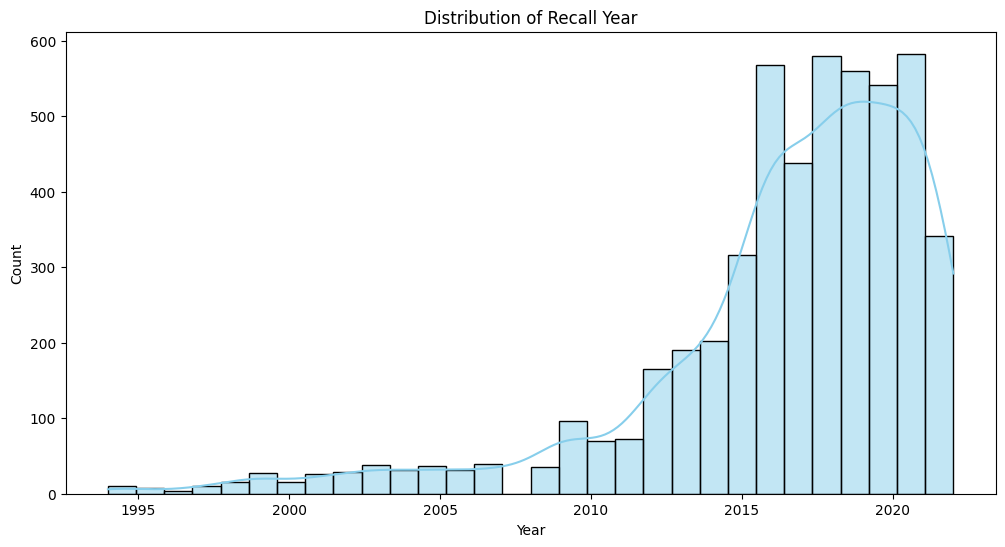

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/2324119332.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='country', data=train_data, order=train_data['country'].value_counts().index, palette='viridis')


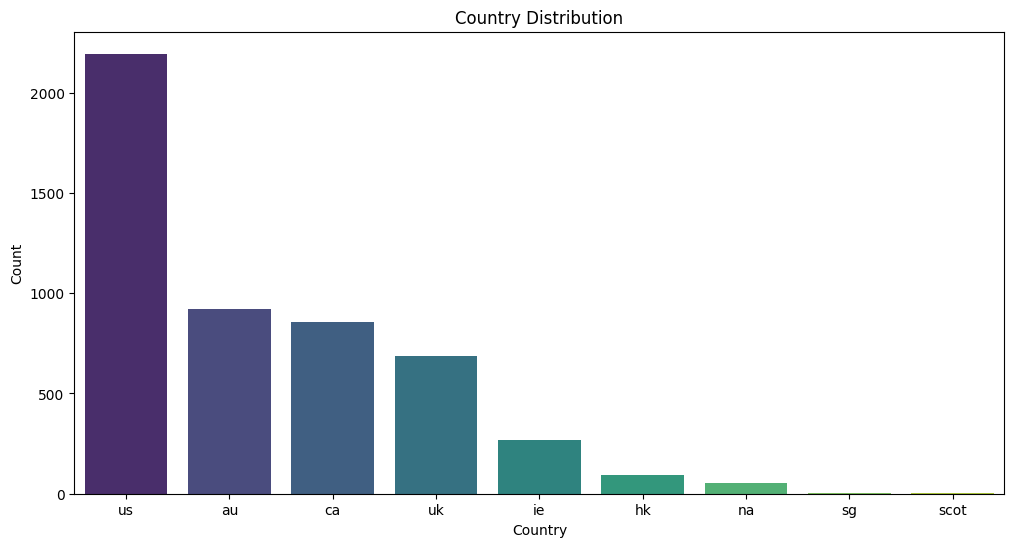

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/2324119332.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='hazard', data=train_data, order=train_data['hazard'].value_counts().index[:20], palette='viridis')  # Show top 20 hazards


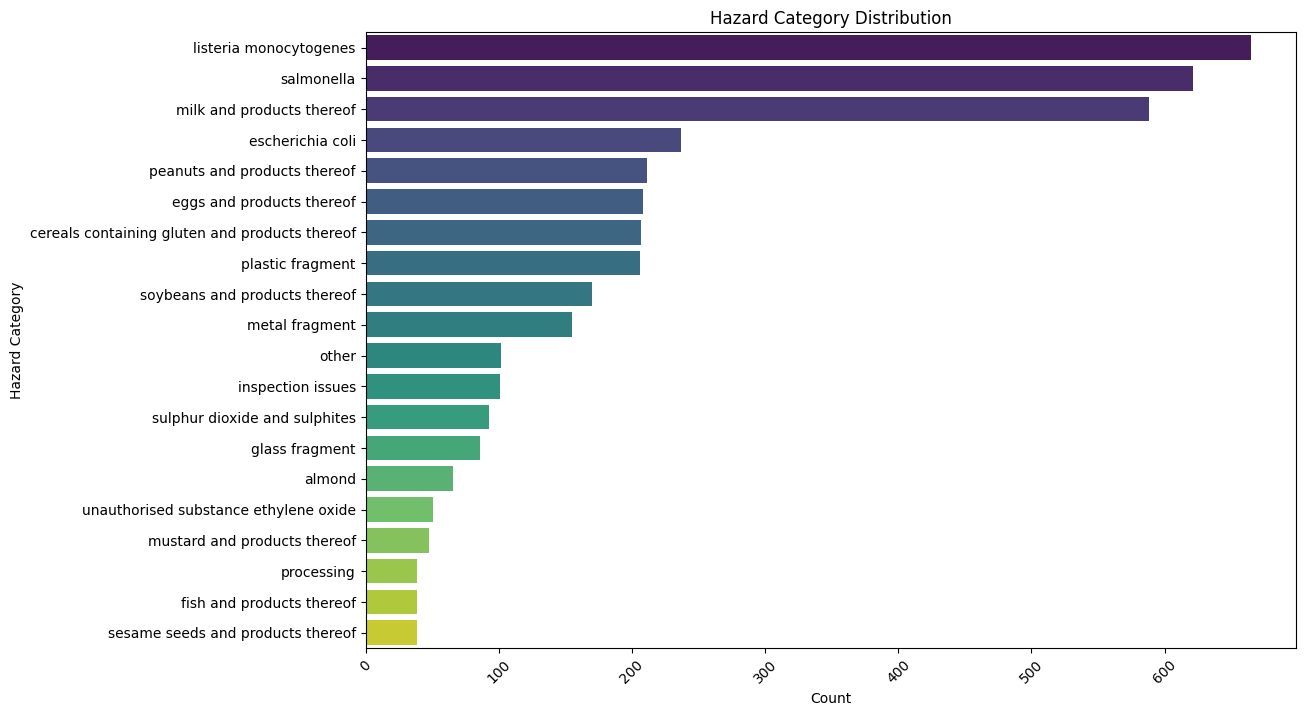

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/2324119332.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='product', data=train_data, order=train_data['product'].value_counts().index[:20], palette='viridis')  # Show top 20 products


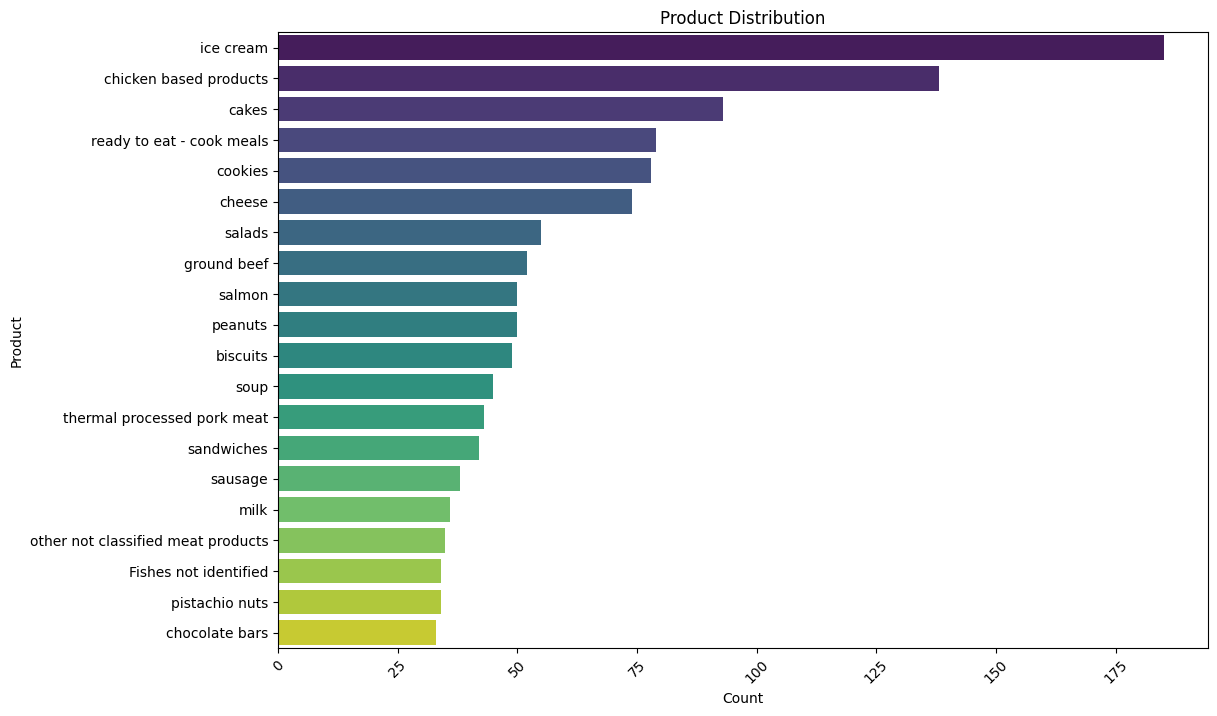

In [24]:
# Plotting the distribution of 'year'
plt.figure(figsize=(12, 6))
sns.histplot(train_data['year'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Recall Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of 'country' values
plt.figure(figsize=(12, 6))
sns.countplot(x='country', data=train_data, order=train_data['country'].value_counts().index, palette='viridis')
plt.title('Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of 'hazard' categories
plt.figure(figsize=(12, 8))
sns.countplot(y='hazard', data=train_data, order=train_data['hazard'].value_counts().index[:20], palette='viridis')  # Show top 20 hazards
plt.title('Hazard Category Distribution')
plt.ylabel('Hazard Category')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()

# Plotting the distribution of 'product' categories
plt.figure(figsize=(12, 8))
sns.countplot(y='product', data=train_data, order=train_data['product'].value_counts().index[:20], palette='viridis')  # Show top 20 products
plt.title('Product Distribution')
plt.ylabel('Product')
plt.xlabel('Count')
plt.xticks(rotation=45)
plt.show()





### **Year Distribution Analysis**

- **Recent Years Dominate**: The majority of the recalls are clustered in recent years, with **2021** (583 occurrences), **2018** (580 occurrences), and **2016** (568 occurrences) having the highest counts. This suggests a higher frequency of food recalls in these years, which could reflect improved reporting, increased awareness, or more regulations.
  
- **Decline in Older Years**: As we look back further in time, the number of recalls decreases significantly. Recalls in **1996** (4 occurrences) and **1997** (10 occurrences) are quite low, indicating that data from these years may not be as comprehensive or frequent. This could also be due to changes in food safety monitoring or reporting standards over time.

- **Limited Data in Early Years**: The data from the **late 1990s** and **early 2000s** shows sparse records, with **1994** (10 occurrences) and **2001** (26 occurrences) being the least represented. This could imply that the dataset may not fully capture recalls in earlier years or that food safety systems were less robust during those periods.

In summary, the distribution of recalls across years is heavily skewed towards the most recent years, with a significant drop-off in older data. This pattern may suggest increased recall awareness and improvements in food safety reporting in more recent times.

---

### **Country Distribution Analysis**

- **Dominance of the United States (US)**: The data is overwhelmingly dominated by the **United States (US)**, with **2195 occurrences**. This suggests that the majority of food recall incidents in this dataset come from the US, possibly due to better tracking and reporting mechanisms in place. Given the US's prominent role in global food safety, this is not surprising.

- **Other Significant Countries**: After the US, the next most frequent countries are **Australia (AU)** with **921 occurrences**, **Canada (CA)** with **856 occurrences**, and the **United Kingdom (UK)** with **687 occurrences**. These countries also have well-established food safety systems and regulations, which may contribute to their higher representation in the dataset.

- **Smaller Representation from Other Regions**: The data from countries like **Ireland (IE)** with **269 occurrences**, **Hong Kong (HK)** with **92 occurrences**, and **Singapore (SG)** with **6 occurrences** show lower numbers of food recalls. These could reflect either fewer recalls or less reporting on food safety incidents in these countries.

In summary, the majority of food recalls in this dataset come from the US, with other countries like Australia, Canada, and the UK following closely behind. The limited representation from other countries could be due to fewer incidents or lower reporting of food safety issues in certain regions.

---

### **Product Distribution Analysis**

- **Most Frequent Products**: The most commonly recalled products include **ice cream** (185 occurrences), **chicken-based products** (138 occurrences), and **cakes** (93 occurrences). These products might be highly susceptible to contamination due to their ingredients, manufacturing processes, or storage conditions, leading to more frequent recalls.

- **Ready-to-Eat and Snack Foods**: Other commonly recalled products include **ready-to-eat cook meals** (79 occurrences), **cookies** (78 occurrences), and **cheese** (74 occurrences). These foods are often prone to recalls due to issues like bacterial contamination (e.g., Listeria in cheese or Salmonella in prepared meals) or allergens.

- **Meats and Seafood**: Meats like **ground beef** (52 occurrences), **sausage** (38 occurrences), and **thermal processed pork meat** (43 occurrences) also show up frequently in recalls. Meat products are particularly vulnerable to contamination by pathogens like Salmonella or E. coli, which can result in widespread recalls.

- **Nuts and Snacks**: Other products like **peanuts** (50 occurrences), **biscuits** (49 occurrences), and **pistachio nuts** (34 occurrences) appear frequently. These products are often subject to recalls due to risks like allergen contamination or contamination during processing.

- **Other Notable Products**: Products like **milk** (36 occurrences), **salads** (55 occurrences), and **chocolate bars** (33 occurrences) are also represented in the data, though less frequently compared to the categories above.

- **Product Diversity**: The dataset includes a wide variety of food products, from **meats** and **dairy** to **snacks** and **desserts**. However, the frequency of recalls is concentrated in specific categories, which may reflect food safety concerns, vulnerability to contamination, or regulatory measures for certain product types.

In summary, the `product` distribution shows a focus on common food items, especially those prone to contamination or those that are sensitive to quality control issues (e.g., meats, ready-to-eat meals, and snacks).

---

### **Hazard Distribution Analysis**

- **Most Common Hazards**: The two most frequently occurring hazards are **Listeria monocytogenes** (665 occurrences) and **Salmonella** (621 occurrences). Both of these are biological hazards, often linked to contamination in ready-to-eat foods and meats. Their high frequency in the dataset could be indicative of the importance of monitoring for these pathogens in food safety protocols.

- **Milk and Other Biological Hazards**: The third most common hazard is **milk and products thereof** (588 occurrences), which suggests concerns related to contamination in dairy products. Other significant biological hazards include **Escherichia coli (237 occurrences)**, **Peanuts and products thereof (211 occurrences)**, and **Eggs and products thereof (208 occurrences)**. These hazards are typically associated with foodborne illnesses and are highly regulated to prevent outbreaks.

- **Allergens and Other Chemical Hazards**: Hazards like **Soybeans and products thereof (170 occurrences)** and **Cereals containing gluten and products thereof (207 occurrences)** are indicative of allergens. These are critical for individuals with food sensitivities, which is why such products are often recalled. **Metal fragments (155 occurrences)** and **Plastic fragments (206 occurrences)** are common contaminants in food products, and their presence in recalls highlights the importance of safety in packaging and manufacturing.

- **Other Notable Hazards**: A variety of other hazards are represented, including **Glass fragments (86 occurrences)**, **Sulphur dioxide and sulphites (93 occurrences)**, **Mustard and products thereof (48 occurrences)**, and **Unauthorised substances like ethylene oxide (51 occurrences)**. These could reflect either contamination during food processing or undeclared allergens or additives that may not have been detected initially.

- **Uncommon Hazards**: Hazards like **processing issues (39 occurrences)** and **fish and products thereof (39 occurrences)** appear less frequently. The “other” category (102 occurrences) could also point to miscellaneous or less common hazards not explicitly listed in the dataset.

In summary, the distribution of `hazards` shows that biological hazards like **Listeria monocytogenes** and **Salmonella** are most frequent, but allergens (such as **milk**, **peanuts**, and **soybeans**) and physical contaminants (like **plastic** and **metal fragments**) also appear frequently. This distribution highlights the variety of risks that can lead to food recalls, with a particular emphasis on microbiological and allergenic hazards.

---

### Month and Day Analysis

#### Why is it interesting to check the **Month** and **Day** columns?

Exploring the **Month** and **Day** columns can provide valuable insights into any temporal trends or patterns in food recalls. Understanding how food recalls are distributed over time can help us identify potential seasonality or periodic spikes in food safety issues.

- **Month Analysis**: By examining the distribution of food recalls across different months, we can assess if certain months of the year are more prone to food recalls. For instance, holidays or seasonal changes in food consumption may lead to increased risks of contamination or other issues.
  
- **Day of the Month Analysis**: Investigating the **Day** column allows us to explore if there are any specific days of the month with higher recall activity. It could be that certain days, such as the first of the month, coincide with regular audits, reports, or increased activity in the food industry that leads to a higher number of recalls. Identifying such patterns may uncover insights into how food recalls are reported or processed.

By understanding these temporal aspects, we can not only improve our predictive models but also gain a better understanding of how food safety risks manifest over time.

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/1431482563.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='month', order=train_data['month'].value_counts().index, palette='viridis')


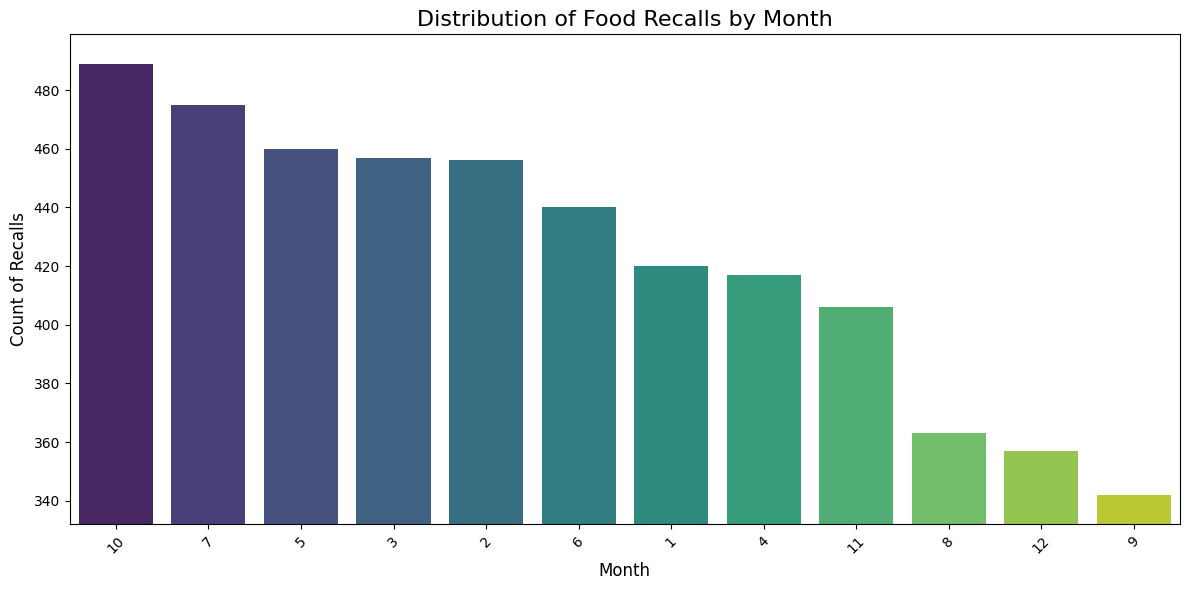

/var/folders/7m/tn2lww617kl3zw0vkb4p06q80000gp/T/ipykernel_62973/1431482563.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='day', order=train_data['day'].value_counts().index, palette='plasma')


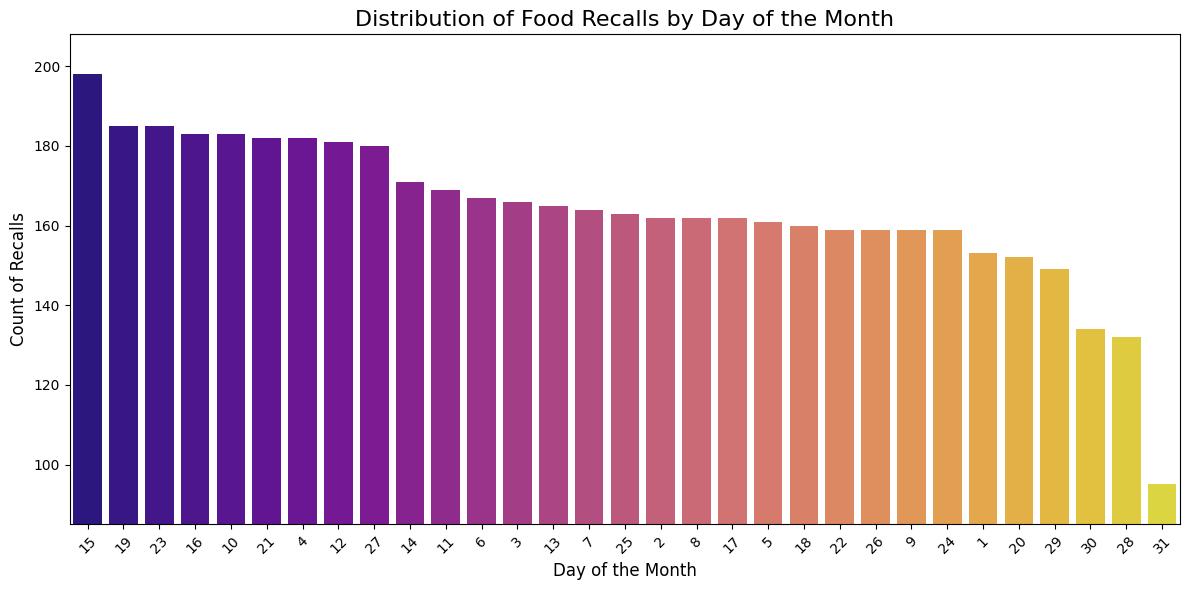

In [37]:
# Plotting the distribution of recalls by month
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='month', order=train_data['month'].value_counts().index, palette='viridis')
plt.title('Distribution of Food Recalls by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count of Recalls', fontsize=12)
plt.ylim(train_data['month'].value_counts().min() - 10, train_data['month'].value_counts().max() + 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the distribution of recalls by day of the month
plt.figure(figsize=(12, 6))
sns.countplot(data=train_data, x='day', order=train_data['day'].value_counts().index, palette='plasma')
plt.title('Distribution of Food Recalls by Day of the Month', fontsize=16)
plt.xlabel('Day of the Month', fontsize=12)
plt.ylabel('Count of Recalls', fontsize=12)
plt.ylim(train_data['day'].value_counts().min() - 10, train_data['day'].value_counts().max() + 10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Month Distribution Analysis

The distribution of food recalls by **month** shows that the months with the highest number of recalls are **October (489)**, **July (475)**, and **May (460)**. These months are relatively close in terms of recall counts, which suggests that food safety incidents might be more frequent during these months. The months with fewer recalls are typically **September (342)** and **December (357)**, with slightly lower counts compared to other months. 

Interestingly, this distribution does not show a significant seasonal variation, indicating that food safety issues can occur throughout the year.

### Day of the Month Distribution Analysis

The **day of the month** distribution reveals a more evenly spread pattern, with the most common days for food recalls being the **15th (198)**, **19th (185)**, and **23rd (185)**. These days seem to appear more frequently, which could indicate periodic reporting or other operational patterns.

On the other hand, **days 28th (132)** and **31st (95)** have the fewest recalls. This lower number could be due to these days occurring less often in a year (as some months have fewer than 31 days), or they may simply not align with higher recall frequencies.

This distribution suggests that there might be no clear pattern for the exact day of the month.

### Title and Text Analysis

#### Why is it interesting to check the **Title** and **Text** columns?

The **Title** and **Text** columns contain crucial information about the food recall incidents. Analyzing these textual features can help us understand the nature of the recalls and provide insights into the risk levels associated with different food products. Here's why it’s interesting to explore these columns:

- **Title Analysis**: The **Title** column typically contains brief summaries or alerts about the food recall incidents. By analyzing the distribution of keywords, phrases, or specific terms in the titles, we can get a quick sense of the types of issues being reported. For instance, certain keywords like “salmonella,” “listeria,” or “plastic fragments” may appear frequently, indicating common hazards or types of contamination in the food supply.
  
- **Text Analysis**: The **Text** column, containing more detailed descriptions, offers a deeper look into the incidents. It can provide essential context such as the specific batch numbers, manufacturers involved, and the precise reasons for the recall. This text may contain additional clues that can be used to detect patterns and nuances in food safety hazards that aren’t immediately apparent from the titles alone.

By thoroughly analyzing these textual columns, we can better understand the risks associated with different foods and improve our ability to detect and predict food safety incidents.

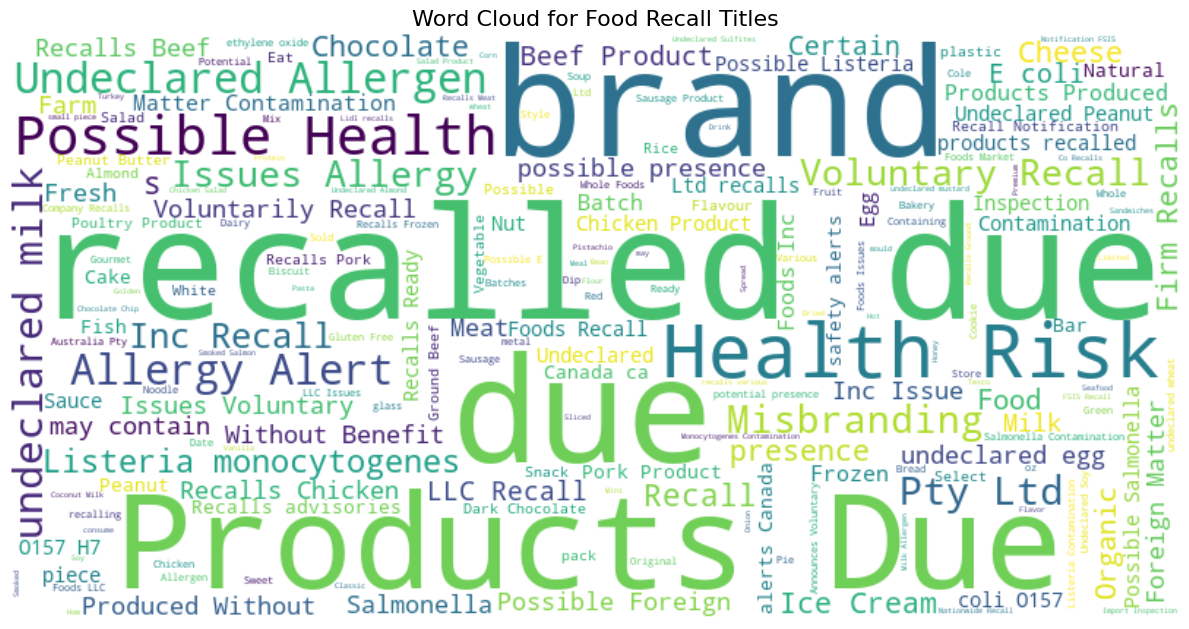

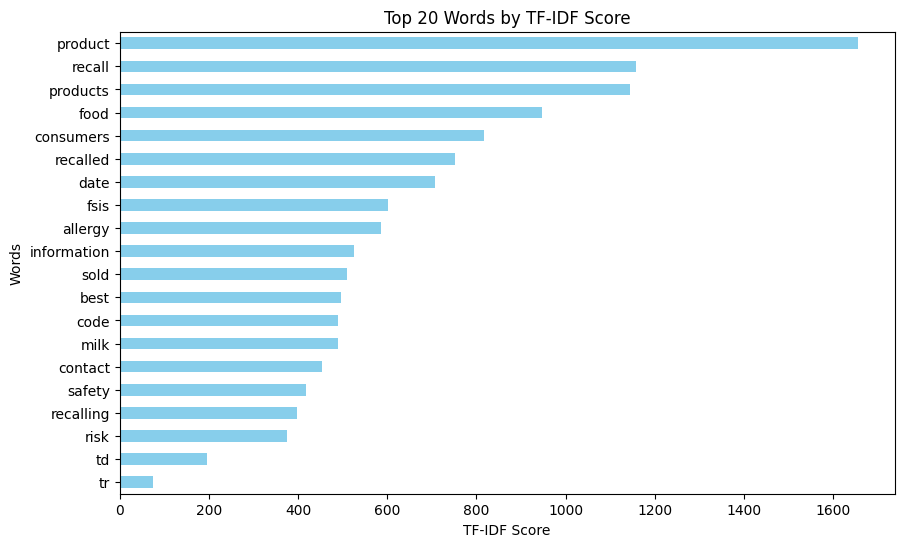

In [ ]:
# Combine all titles into a single text string
title_text = ' '.join(train_data['title'].dropna().astype(str))

# Generate the word cloud for titles
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title_text)

# Plot the word cloud for titles
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Food Recall Titles', fontsize=16)
plt.tight_layout()
plt.show()


# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)

# Fit and transform the text data
X = vectorizer.fit_transform(train_data['text'].dropna())

# Display the top 20 most significant words
features = vectorizer.get_feature_names_out()
top_words = pd.DataFrame(X.toarray(), columns=features).sum().sort_values(ascending=False).head(20)

# Plotting the top 20 words based on their TF-IDF scores
plt.figure(figsize=(10, 6))
top_words.plot(kind='barh', color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title('Top 20 Words by TF-IDF Score')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest TF-IDF score at the top
plt.show()


### Conclusions from Title and Text Analysis

From the analysis of the most frequent words (as visualized in the word cloud) and the TF-IDF scores, we can draw several conclusions about the nature of food recalls:

1. **Recall Focus**: Terms like **'recalled'**, **'recall'**, and **'recalled due'** dominate, highlighting that the core of the dataset is food recalls.

2. **Health Risks**: There is significant concern with **'Health Risk'**, **'Allergy Alert'**, and allergens like **'milk'** and **'peanuts'**. This suggests that allergens are a major driver for food recalls.

3. **Regulatory Involvement**: Words such as **'fsis'** (Food Safety and Inspection Service) and **'Inc Recall'** underscore the importance of regulatory bodies in the recall process.

4. **Product-Specific Issues**: Products like **'Ice Cream'** and **'Cheese'** are frequently mentioned, indicating that some food categories (as we saw earlier) are more prone to recalls.

### Overall Implications:
The most frequent and TF-IDF significant words suggest that food recalls are heavily driven by health risks, particularly those associated with allergens and microbial contamination.

In conclusion, understanding the most frequent words and TF-IDF scores provides valuable insight into the underlying causes of food recalls, emphasizing the importance of safety measures, proper labeling, and swift, transparent communication in the food industry.

## Step 2: Benchmark Analysis 1 - Short Texts (Titles)

In this section, we will train machine learning models on the **short texts (titles)** and evaluate their performance. We will first preprocess the text and then train both basic models (Logistic Regression and Naive Bayes) as well as an advanced transformer-based model (BERT).

### Data Preprocessing for Short Texts


In [58]:
# Preprocess short text (title) - cleaning and vectorization

# Define a function to preprocess the text (removing special characters, stopwords, etc.)
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])  # Remove stopwords
    return text

# Apply preprocessing to the 'title' column
train_data['cleaned_title'] = train_data['title'].apply(preprocess_text)

# Display the cleaned titles
train_data['cleaned_title'].head()


0    recall notification fsis02494
1    recall notification fsis03394
2    recall notification fsis01494
3    recall notification fsis00994
4    recall notification fsis00194
Name: cleaned_title, dtype: object

### TF-IDF Vectorization for Short Texts

Next, we'll use **TF-IDF Vectorization** to convert the preprocessed titles into numerical features suitable for machine learning models.


In [61]:
# TF-IDF Vectorization for the short texts (titles)
vectorizer = TfidfVectorizer(max_features=5000)
X_title = vectorizer.fit_transform(train_data['cleaned_title'])
y_product = train_data['product-category']
y_hazard = train_data['hazard-category']

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_title, y_product, test_size=0.2, random_state=42)


# TF-IDF Vectorization for the short texts (titles)
vectorizer = TfidfVectorizer(max_features=5000)
X_title = vectorizer.fit_transform(train_data['cleaned_title'])
y_product = train_data['product-category']
y_hazard = train_data['hazard-category']

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_title, y_product, test_size=0.2, random_state=42)


### Model 1: Logistic Regression (Baseline)

We will start with **Logistic Regression**, a basic model, to serve as a benchmark for text classification.

In [64]:
# Train a Logistic Regression model on short texts (titles)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluate the model on the validation set
lr_preds = lr_model.predict(X_val)
print(classification_report(y_val, lr_preds))


                                                   precision    recall  f1-score   support

                              alcoholic beverages       1.00      0.14      0.25         7
                      cereals and bakery products       0.57      0.80      0.66       123
     cocoa and cocoa preparations, coffee and tea       0.75      0.55      0.64        49
                                    confectionery       1.00      0.10      0.18        40
dietetic foods, food supplements, fortified foods       1.00      0.54      0.70        24
                                    fats and oils       0.00      0.00      0.00         4
                                   feed materials       0.00      0.00      0.00         3
                           food contact materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.70      0.71      0.70       112
                                 herbs and spices       0.67      0.25      0.36        1

/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model 2: Naive Bayes (Baseline)

We'll also try the **Naive Bayes** model for text classification, which is another simple but effective approach for text-based tasks.

In [67]:
# Train a Naive Bayes model on short texts (titles)
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
nb_preds = nb_model.predict(X_val)
print(classification_report(y_val, nb_preds))

                                                   precision    recall  f1-score   support

                              alcoholic beverages       0.00      0.00      0.00         7
                      cereals and bakery products       0.43      0.67      0.52       123
     cocoa and cocoa preparations, coffee and tea       1.00      0.06      0.12        49
                                    confectionery       1.00      0.03      0.05        40
dietetic foods, food supplements, fortified foods       1.00      0.04      0.08        24
                                    fats and oils       0.00      0.00      0.00         4
                                   feed materials       0.00      0.00      0.00         3
                           food contact materials       0.00      0.00      0.00         1
                            fruits and vegetables       0.67      0.52      0.59       112
                                 herbs and spices       0.00      0.00      0.00        1

/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/Omni/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
